In [1]:
import os
import os.path as osp
import random
import re
from collections import defaultdict
from glob import glob

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

plt.style.use("default")

from scipy import ndimage
from tqdm import tqdm

from utils import compute_head_mask, load_volume, get_lesion_size

## Analysis Outline

In this section, we are going to perform an Explorative Data Analysis (EDA) on both ATLAS and ISLES datasets. Specifically, we are going to investigate:
- The class imbalance between background and foreground elements. We are also going to divide the lesions into groups based on their size (e.g., small, medium, large) and analyze their distribution.
- Overall per-patient statistics, such as: median depth and number of lesions, median ratio/number of sick-healthy slices, median lesion size.
- The intensity distribution of MRI volumes (T1w for ATLAS and DWI for ISLES). This wil tell us if the intensity levels are going to be a discriminative feature or not (e.g., lesions are represented as outliers).
- The overall position distributions of lesions to assess whether spatial/location is an actual problem or not.

### Utilities

This section contains common functions that we will use for both ATLAS and ISLES analysis.

In [2]:
def get_volumes_fps(root_dir: str, scans_identifier: str, masks_identifier: str, pattern: str = "**/*",
                    file_ext: str = ".nii.gz"):
    scans_fps = sorted(glob(osp.join(root_dir, f"{pattern}{scans_identifier}{file_ext}"), recursive=True))
    masks_fps = sorted(glob(osp.join(root_dir, f"{pattern}{masks_identifier}{file_ext}"), recursive=True))

    assert len(scans_fps) == len(masks_fps), "there must be an equal number of masks and scans"

    return scans_fps, masks_fps


def robust_normalize_volume(volume, brain_mask=None, p_low=2, p_high=98):
    if brain_mask is None:
        brain_mask = compute_head_mask(volume)
    vals = volume[brain_mask]
    p1, p99 = np.percentile(vals, (p_low, p_high))
    volume = np.clip(volume, p1, p99)
    volume = (volume - p1) / (p99 - p1 + 1e-8)
    return volume


def minmax_normalization(volume, brain_mask=None):
    if brain_mask is None:
        brain_mask = compute_head_mask(volume)
    vals = volume[brain_mask]
    vals_min, vals_max = vals.min(), vals.max()
    return (volume - vals_min) / (vals_max - vals_min + 1e-8)


def z_score_standardization(volume, brain_mask=None):
    if brain_mask is None:
        brain_mask = compute_head_mask(volume)
    vals = volume[brain_mask]
    mean, std = vals.mean(), vals.std() + 1e-8
    return (volume - mean) / (std + 1e-8)


# helper to plot one normalization
def plot_intensity_distr(bin_centers, ax, title, counts, label="Global", alpha=0.7, x_label="Intensity"):
    ax.plot(bin_centers, counts, lw=2, alpha=alpha, label=label)

    ax.set_title(title)
    ax.set_xlabel(x_label)
    ax.set_ylabel("Count")


def make_hist(vals, q=(0.5, 99.5), n_bins=200):
    vmin, vmax = np.percentile(vals, q)
    bins = np.linspace(vmin, vmax, n_bins)

    counts, edges = np.histogram(vals, bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])
    return centers, counts, bins

### ATLAS Analysis

ATLAS 2.0 training set contains 655 T1w MRI scans, each of dimension 197x233x189. The dataset contains lesions spanning from acute to subacute stages, as patients were scanned multiple times to monitor stroke progression over time.

The dataset contains a large amount of data, but we must recognize that most of it comes from the 'duplication' of the same brain being observed at different time intervals. This is a double-edged sword: it may be beneficial to track store evolution over time and construct a model that is able to recognize lesions at different life stages, but it could also harm the training process by presenting the same brain with little to no change multiple times.
Medical datasets, especially stroke lesions dataset, are known to suffer from extreme data imbalance (ATLAS 2.0 is no stranger). In this context, the latter concern is more likely to dominate. Moreover, repeatedly analyzing scans from the same subject may introduce statistical bias and noise, potentially confounding results and interpretations. Consequently, for the purposes of this EDA, we choose to randomly select a single session per patient, reducing the effective number of scans from 655 to 33.

In [12]:
ATLAS_ROOT_DIR = "data/ATLAS_2/Training"
ATLAS_SCANS_IDENTIFIER = "T1w*"
ATLAS_MASKS_IDENTIFIER = "T1lesion_mask*"

scans_fps, masks_fps = get_volumes_fps(ATLAS_ROOT_DIR, ATLAS_SCANS_IDENTIFIER, ATLAS_MASKS_IDENTIFIER)

print(f"ATLAS: #scans: {len(scans_fps)}, #masks: {len(masks_fps)}")


# since each patient has been scanned more than once, we randomly select one session per patient
def get_subject_id(fp):
    basename = os.path.basename(fp)
    prefix = basename.split("_")[0]  # expects 'sub-rXXXsXXX...' format
    return re.split(r"s(\d+)", prefix)[0].split("-")[1]  # extracts 'rXXX'


def get_subject_and_session(fp):
    basename = os.path.basename(fp)
    prefix = basename.split("_ses")[0]  # expects 'sub-rXXXsXXX_rest_of_the_filename...' format
    return re.search(r"r(\d+)s(\d+)", prefix).group()  # extracts 'rXXXsYYY'


# # choose one session per patient
# i = 0
# subjects = defaultdict(set)
# for scan_fp in scans_fps:
#     subject_id = get_subject_id(scan_fp)
#     subjects[subject_id].add(get_subject_and_session(scan_fp))
#
# chosen_sessions = []
#
# for subject in subjects.keys():
#     sessions = list(subjects[subject])
#     session = random.choice(sessions)
#     chosen_sessions.append(session)
#
# # filter out not chosen sessions
# scans_fps = [fp for fp in scans_fps if get_subject_and_session(fp) in chosen_sessions]
# masks_fps = [fp for fp in masks_fps if get_subject_and_session(fp) in chosen_sessions]

print(f"ATLAS Unique Session: #scans: {len(scans_fps)}, #masks: {len(masks_fps)}")

LESION_SIZES = ["No Lesion", "Small", "Medium", "Large"]
metadata = {
    "healthy_slices": [],
    "sick_slices": [],
    "lesions": [],
    "sick_voxels": [],
    "healthy_voxels": []
}

for label in LESION_SIZES:
    metadata[label] = []

for scan_fp, mask_fp in tqdm(zip(scans_fps, masks_fps), total=len(scans_fps), desc="Collecting metadata"):
    mask = load_volume(mask_fp)
    scan = load_volume(scan_fp)
    brain_mask = compute_head_mask(scan)

    sick_slices = mask.any(axis=(0, 1))
    healthy_slices = ~sick_slices

    # get number of lesions/connected components
    labeled_mask, num_lesions = ndimage.label(mask)

    metadata["lesions"].append(num_lesions)
    metadata["healthy_slices"].append(np.sum(healthy_slices))
    metadata["sick_slices"].append(np.sum(sick_slices))

    sick_voxels_per_patient = 0.0
    healthy_voxels_per_patient = 0.0

    for z_idx in range(mask.shape[-1]):
        mask_slice = mask[..., z_idx]
        brain_mask_slice = brain_mask[..., z_idx]

        lesion_size_label, lesion_size, lesion_area = get_lesion_size(brain_mask_slice, mask_slice, get_head_mask=False, return_all=True)
        metadata[lesion_size_label].append(lesion_area)

        mask_slice = np.astype(mask_slice, np.bool)
        sick_tissue = (brain_mask_slice * mask_slice)
        healthy_tissue = (brain_mask_slice * ~mask_slice)
        sick_voxels_per_patient += np.sum(sick_tissue)
        healthy_voxels_per_patient += np.sum(healthy_tissue)

    metadata["sick_voxels"].append(sick_voxels_per_patient)
    metadata["healthy_voxels"].append(healthy_voxels_per_patient)

    del mask, scan


ATLAS: #scans: 608, #masks: 608
ATLAS Unique Session: #scans: 608, #masks: 608


  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)


#### Class Imbalance

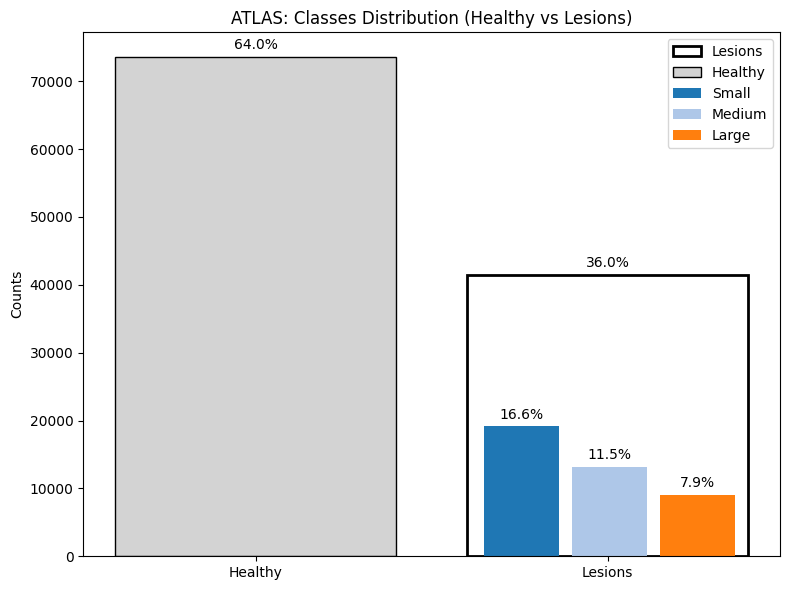

In [13]:
size_counts = [len(metadata[size]) for size in LESION_SIZES]
total = np.sum(size_counts)

no_lesion_count = size_counts[LESION_SIZES.index("No Lesion")]
sick_counts = [size_counts[LESION_SIZES.index(s)] for s in LESION_SIZES[1:]]
sick_total = sum(sick_counts)

# sort in descending order
items = zip(size_counts, LESION_SIZES)
sorted_items = sorted(items, key=lambda x: x[0], reverse=True)

sizes_distribution = {}

for (count, label) in sorted_items:
    percentage = count * 100 / total
    sizes_distribution[label] = {"percentage": percentage, "count": count}

fig, ax = plt.subplots(figsize=(8, 6))

# positions for healthy and sick groups
x_healthy = 0
x_sick = 1
outer_width = 0.8

# outer sick bar (total)
ax.bar(x_sick, sick_total, width=outer_width,
       edgecolor="black", facecolor="none", linewidth=2, label="Lesions")

# healthy bar
ax.bar(x_healthy, no_lesion_count, width=outer_width,
       color="lightgray", edgecolor="black", label="Healthy")

# inner bars for Small / Medium / Large, side by side inside the sick bar
inner_labels = ["Small", "Medium", "Large"]
inner_vals = sick_counts
n_inner = len(inner_labels)
inner_width = outer_width / n_inner * 0.8
offsets = np.linspace(-outer_width / 2 + 0.05, outer_width / 2, n_inner, endpoint=False) + inner_width / 2

colors = plt.cm.tab20.colors

for off, val, lab, c in zip(offsets, inner_vals, inner_labels, colors):
    pct = val * 100 / total
    ax.bar(x_sick + off, val, width=inner_width, color=c, label=lab)
    ax.text(x_sick + off, val + 0.01 * total, f"{pct:.1f}%", ha="center")

# x‑axis
ax.set_xticks([x_healthy, x_sick])
ax.set_xticklabels(["Healthy", "Lesions"])

ax.set_ylabel("Counts")
ax.set_title("ATLAS: Classes Distribution (Healthy vs Lesions)")

for x, val in [(x_healthy, no_lesion_count), (x_sick, sick_total)]:
    pct = val * 100 / total
    ax.text(x, val + 0.01 * total, f"{pct:.1f}%", ha="center")

ax.legend()
plt.tight_layout()
plt.show()


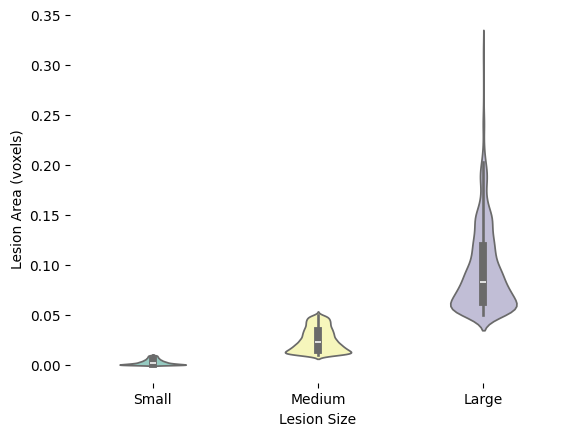

In [5]:
# violin plots to see how is the size distribution inside each lesion size category
records = []
for size in LESION_SIZES[1:]:
    for area in metadata[size]:
        records.append(({"Lesion Size": size, "Lesion Area (voxels)": area}))

df = pd.DataFrame(records, columns=["Lesion Area (voxels)", "Lesion Size"])


sns.violinplot(data=df, x="Lesion Size", y="Lesion Area (voxels)", hue="Lesion Size", palette="Set3", gap=0.5)
sns.despine(left=True, bottom=True)

#### General Statistics

In [6]:
H, W = 197, 233
TOT_AREA = H * W

median_sick_voxels = np.median(metadata["sick_voxels"])
median_healthy_voxels = np.median(metadata["healthy_voxels"])
median_num_lesions = np.median(metadata["lesions"])
median_sick_slices = np.median(metadata["sick_slices"])
median_healthy_slices = np.median(metadata["healthy_slices"])

median_lesion_size = None
curr_mode = float("-inf")
median_lesion_area = 0.0
for size in LESION_SIZES[1:]:
    if curr_mode < len(metadata[size]):
        median_lesion_size = size
        curr_mode = len(metadata[size])
        median_lesion_area = np.median(metadata[size])

print(f"Median sick voxels per patient: {median_sick_voxels}/{TOT_AREA}\n"
      f"Median healthy voxels per patient: {median_healthy_voxels}/{TOT_AREA}\n"
      f"Median healthy/sick voxels ratio: 1:{(median_healthy_voxels / median_sick_voxels):.0f}\n"
      f"Median sick slices: {median_sick_slices}\n"
      f"Median healthy slices: {median_healthy_slices}\n"
      f"Median healthy/sick slices ratio: 1:{(median_healthy_slices / median_sick_slices):.0f}\n"
      f"Median number of lesions per patient: {median_lesion_size}\n"
      f"Median lesion size: '{median_lesion_size}'\n"
      f"Median lesion area: {median_lesion_area:.4f} - {(TOT_AREA * median_lesion_area):.0f}/{TOT_AREA} voxels")


Median sick voxels per patient: 5232.0/45901
Median healthy voxels per patient: 3698368.0/45901
Median healthy/sick voxels ratio: 1:707
Median sick slices: 45.0
Median healthy slices: 144.0
Median healthy/sick slices ratio: 1:3
Median number of lesions per patient: Small
Median lesion size: 'Small'
Median lesion area: 0.0022 - 101/45901 voxels


#### Lesion Position Distribution

Computing location heatmap: 100%|██████████| 655/655 [01:37<00:00,  6.70it/s]


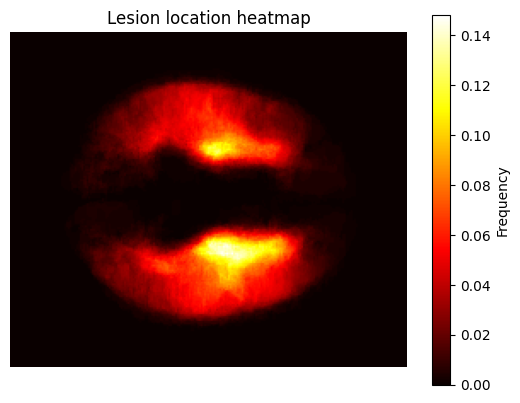

In [7]:
heatmap = None

for mask_fp in tqdm(masks_fps, desc="Computing location heatmap"):
    mask = load_volume(mask_fp)

    if heatmap is None:
        heatmap = np.zeros_like(mask)

    heatmap += (mask > 0).astype(np.float32)

heatmap /= len(masks_fps)

if heatmap.ndim == 3:
    mid_slice = heatmap.shape[-1] // 2
    heatmap = heatmap[..., mid_slice]

plt.imshow(heatmap, cmap="hot")
plt.colorbar(label="Frequency")
plt.title(f"Lesion location heatmap")
plt.axis("off")
plt.show()

#### Intensity Distribution

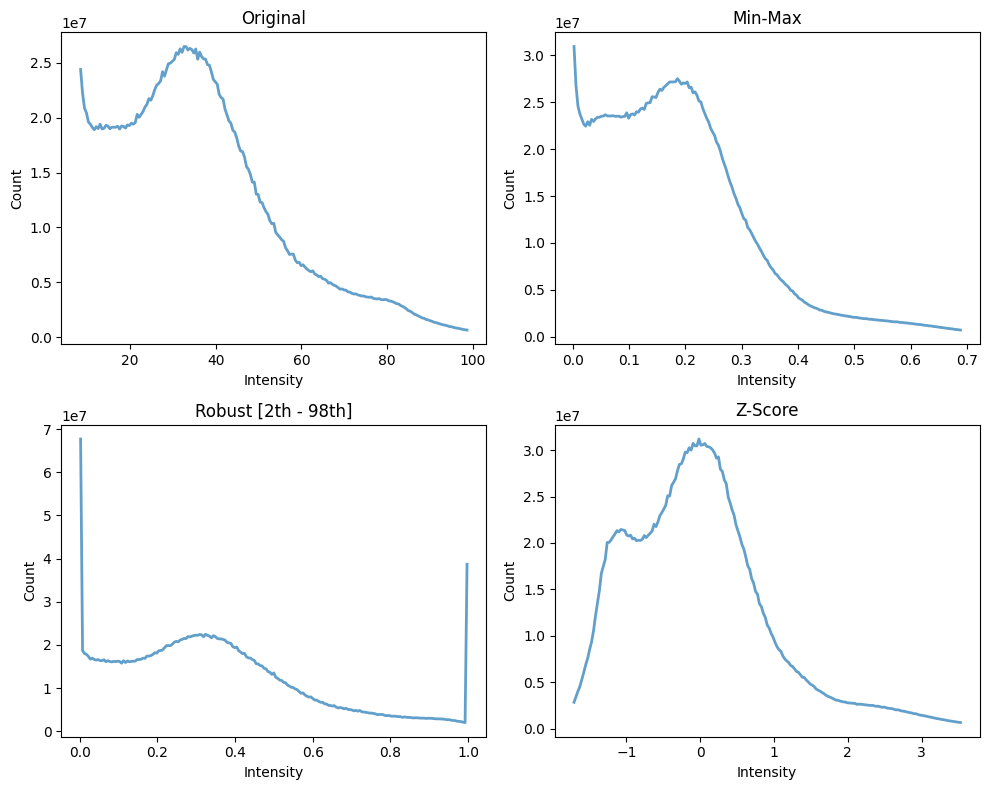

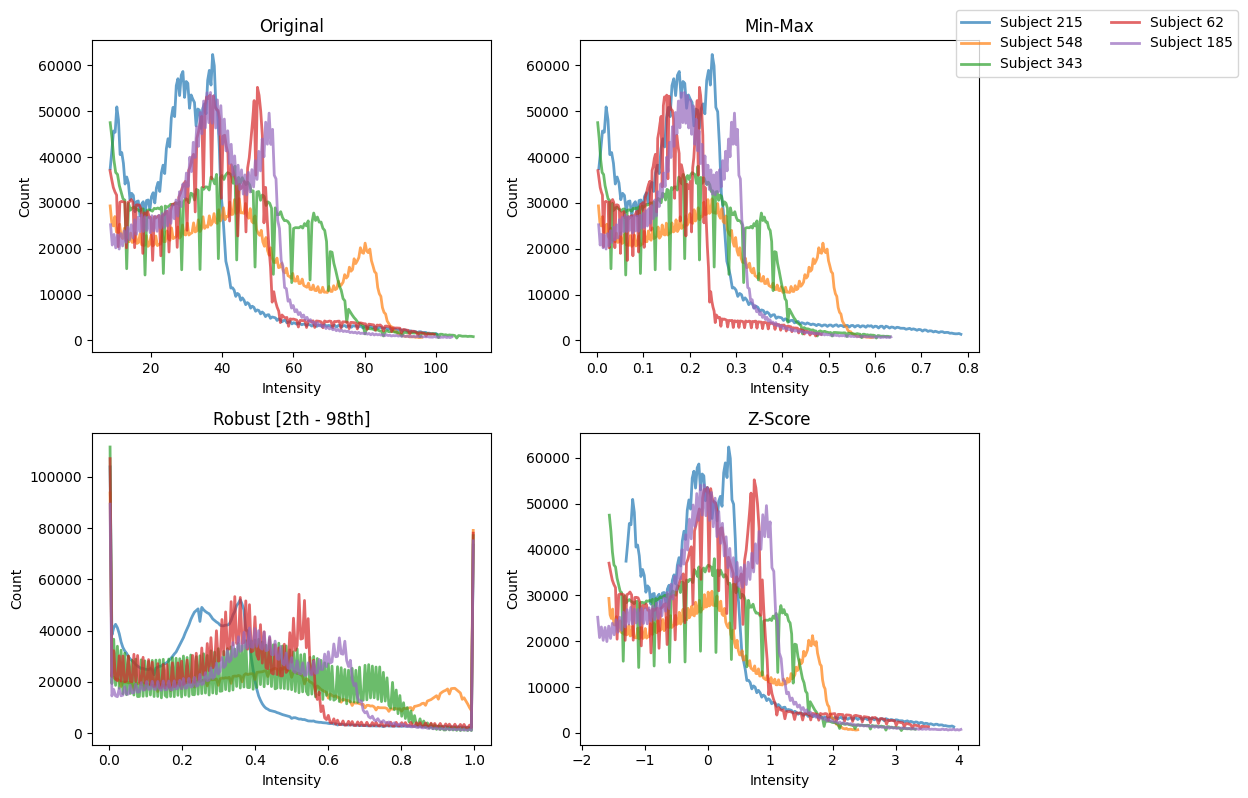

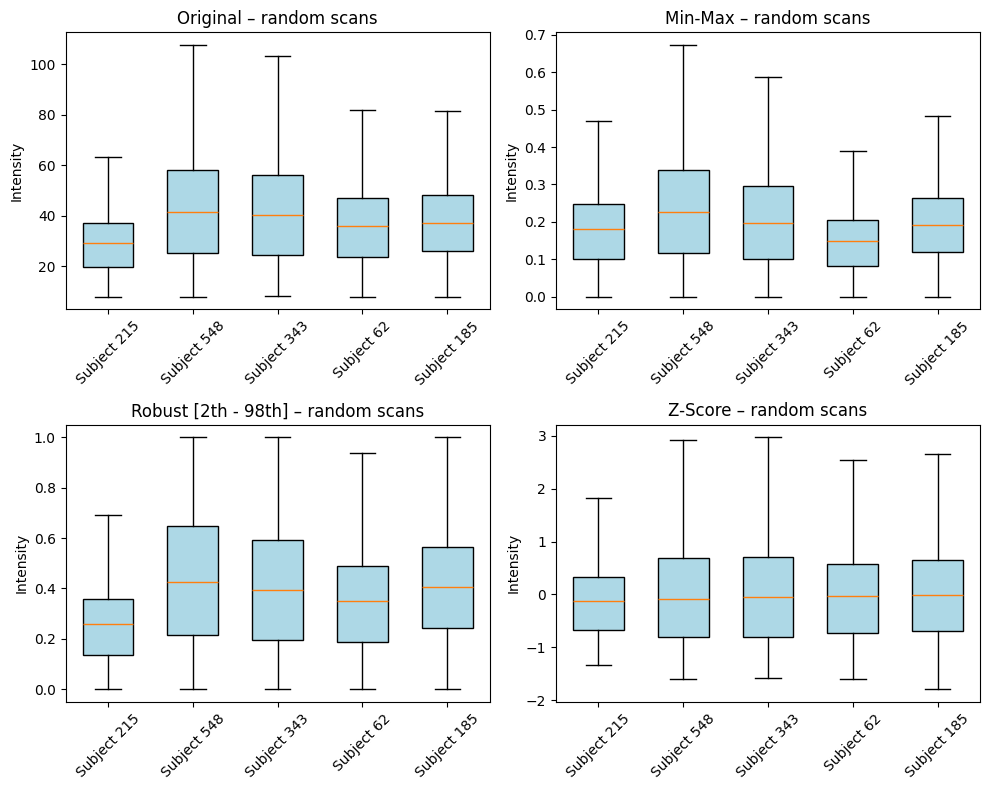

In [8]:
# collect global intensities
raw_intensities = []
robust_intensities = []
minmax_intensities = []
zscore_intensities = []

# we load scan one by one and then discard them to save memory
for scan_fp in tqdm(scans_fps, total=len(scans_fps), desc="Collecting global intensities"):
    scan = load_volume(scan_fp)
    brain_mask = compute_head_mask(scan)

    robust_volume = robust_normalize_volume(scan, brain_mask)
    zscore_volume = z_score_standardization(scan, brain_mask)
    minmax_volume = minmax_normalization(scan, brain_mask)

    raw_intensities.append(scan[brain_mask].ravel())
    robust_intensities.append(robust_volume[brain_mask].ravel())
    zscore_intensities.append(zscore_volume[brain_mask].ravel())
    minmax_intensities.append(minmax_volume[brain_mask].ravel())

    del scan, brain_mask

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

all_intensities = [raw_intensities, minmax_intensities, robust_intensities, zscore_intensities]

titles = ["Original", "Min-Max", "Robust [2th - 98th]", "Z-Score"]

for ax, title, intensities in zip(axes, titles, all_intensities):
    intensities = np.concatenate(intensities)
    centers, counts, _ = make_hist(intensities)
    plot_intensity_distr(centers, ax, title, counts)

# plot random individual intensity distributions
fig.tight_layout()
plt.show()

n_random = 5
n_scans = len(all_intensities[0])
rand_ids = random.sample(range(n_scans), k=n_random)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, title, intensities in zip(axes, titles, all_intensities):
    random_intensities = [intensities[i] for i in rand_ids]
    # overlay a subset of scans
    for _i, intens in enumerate(random_intensities):
        centers, counts, _ = make_hist(intens)
        plot_intensity_distr(centers, ax, title, counts, label=f"Subject {rand_ids[_i]}" if ax is axes[0] else None)

# global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.25, 1), ncol=2)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, title, intensities in zip(axes, titles, all_intensities):
    # collect 1D arrays for the chosen scans
    data = [intensities[i] for i in rand_ids]

    # positions for grouped boxplots (one group per scan id)
    # here: normalization fixed, scans vary along x
    positions = np.arange(n_random)

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=False,
    )

    # simple coloring
    for box in bp["boxes"]:
        box.set(facecolor="lightblue")

    ax.set_xticks(positions)
    ax.set_xticklabels([f"Subject {i}" for i in rand_ids], rotation=45)
    ax.set_ylabel("Intensity")
    ax.set_title(f"{title} – random scans")

fig.tight_layout()
plt.show()

# ISLES Analysis

In [20]:
ISLES_ROOT_DIR = "data/ISLES-2022/"
ISLES_SCANS_IDENTIFIER = "sequences/**/*/*dwi*"
ISLES_MASKS_IDENTIFIER = "derivatives/**/*/*msk*"

scans_fps, masks_fps = get_volumes_fps(ISLES_ROOT_DIR, ISLES_SCANS_IDENTIFIER, ISLES_MASKS_IDENTIFIER, pattern="")

print(f"ISLES: #scans: {len(scans_fps)}, #masks: {len(masks_fps)}")

LESION_SIZES = ["No Lesion", "Small", "Medium", "Large"]
metadata = {
    "healthy_slices": [],
    "sick_slices": [],
    "lesions": [],
    "sick_voxels": [],
    "healthy_voxels": []
}

for label in LESION_SIZES:
    metadata[label] = []

for scan_fp, mask_fp in tqdm(zip(scans_fps, masks_fps), total=len(scans_fps), desc="Collecting metadata"):
    mask = load_volume(mask_fp)
    scan = load_volume(scan_fp)
    brain_mask = compute_head_mask(scan)

    sick_slices = mask.any(axis=(0, 1))
    healthy_slices = ~sick_slices

    # get number of lesions/connected components
    labeled_mask, num_lesions = ndimage.label(mask)

    metadata["lesions"].append(num_lesions)
    metadata["healthy_slices"].append(np.sum(healthy_slices))
    metadata["sick_slices"].append(np.sum(sick_slices))

    sick_voxels_per_patient = 0.0
    healthy_voxels_per_patient = 0.0

    for z_idx in range(mask.shape[-1]):
        mask_slice = mask[..., z_idx]
        brain_mask_slice = brain_mask[..., z_idx]

        lesion_size_label, lesion_size, lesion_area = get_lesion_size(brain_mask_slice, mask_slice, get_head_mask=False, return_all=True)
        metadata[lesion_size_label].append(lesion_area)

        mask_slice = np.astype(mask_slice, np.bool)
        sick_tissue = (brain_mask_slice * mask_slice)
        healthy_tissue = (brain_mask_slice * ~mask_slice)
        sick_voxels_per_patient += np.sum(sick_tissue)
        healthy_voxels_per_patient += np.sum(healthy_tissue)

    metadata["sick_voxels"].append(sick_voxels_per_patient)
    metadata["healthy_voxels"].append(healthy_voxels_per_patient)

    del mask, scan


ISLES: #scans: 250, #masks: 250


  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
/media/neurone-pc13/7FD0B7F50A4D7BEE/Angelo/strokeformer/utils/helpers.py:245: RuntimeWarning: invalid value encountered in divide
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
/media/neurone-pc13/7FD0B7F50A4D7BEE/Angelo/strokeformer/utils/helpers.py:245: RuntimeWarning: invalid value encountered in divide
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion_area = np.nan_to_num(np.divide(lesion_size, brain_area), nan=0)
  lesion

Computing location heatmap: 100%|██████████| 250/250 [00:09<00:00, 25.65it/s]


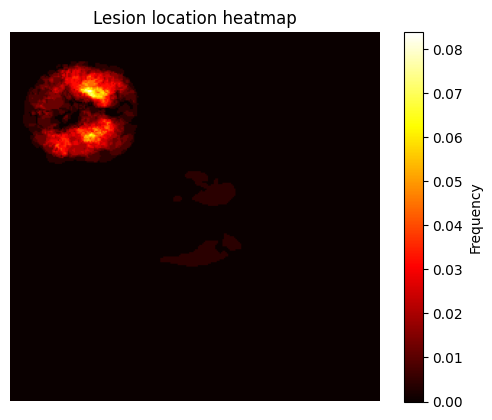

In [25]:
# isles scans are not standardized in spatial dimensions
max_shape = None

for mask_fp in tqdm(masks_fps, desc="Getting max shape"):
    mask = load_volume(mask_fp)

    if max_shape is None:
        max_shape = list(mask.shape)
    else:
        max_shape = [
            max(ms, s) for ms, s in zip(max_shape, mask.shape)
        ]

max_shape = tuple(max_shape)

def pad_to_shape(volume, target_shape):
    pad_width = []
    for s, t in zip(volume.shape, target_shape):
        if s > t:
            raise ValueError("Volume larger than target shape")
        pad_width.append((0, t - s))

    return np.pad(volume, pad_width, mode="constant", constant_values=0)


heatmap = np.zeros(max_shape, dtype=np.float32)

for mask_fp in tqdm(masks_fps, desc="Computing location heatmap"):
    mask = load_volume(mask_fp)
    mask = pad_to_shape(mask, max_shape)

    heatmap += (mask > 0).astype(np.float32)

heatmap /= len(masks_fps)

if heatmap.ndim == 3:
    mid_slice = heatmap.shape[-1] // 2
    heatmap = heatmap[..., mid_slice]

plt.imshow(heatmap, cmap="hot")
plt.colorbar(label="Frequency")
plt.title(f"Lesion location heatmap")
plt.axis("off")
plt.show()

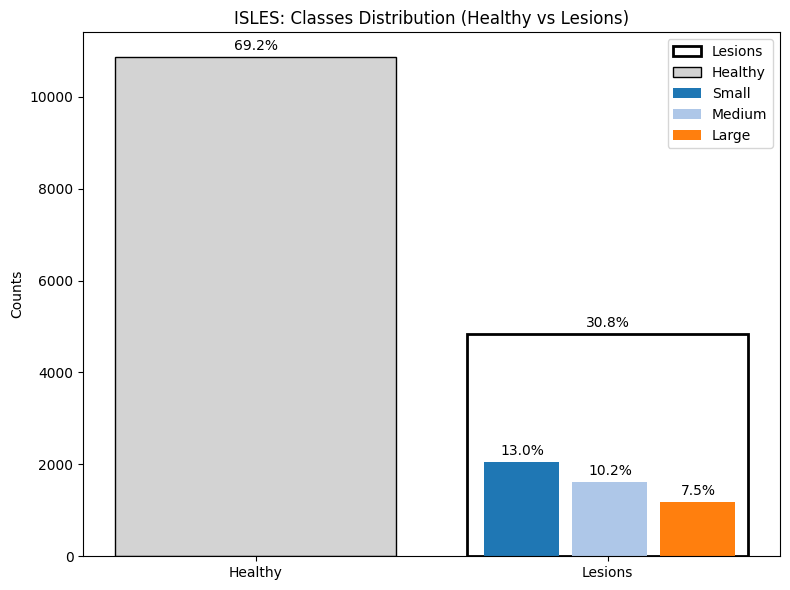

In [22]:
size_counts = [len(metadata[size]) for size in LESION_SIZES]
total = np.sum(size_counts)

no_lesion_count = size_counts[LESION_SIZES.index("No Lesion")]
sick_counts = [size_counts[LESION_SIZES.index(s)] for s in LESION_SIZES[1:]]
sick_total = sum(sick_counts)

# sort in descending order
items = zip(size_counts, LESION_SIZES)
sorted_items = sorted(items, key=lambda x: x[0], reverse=True)

sizes_distribution = {}

for (count, label) in sorted_items:
    percentage = count * 100 / total
    sizes_distribution[label] = {"percentage": percentage, "count": count}

fig, ax = plt.subplots(figsize=(8, 6))

# positions for healthy and sick groups
x_healthy = 0
x_sick = 1
outer_width = 0.8

# outer sick bar (total)
ax.bar(x_sick, sick_total, width=outer_width,
       edgecolor="black", facecolor="none", linewidth=2, label="Lesions")

# healthy bar
ax.bar(x_healthy, no_lesion_count, width=outer_width,
       color="lightgray", edgecolor="black", label="Healthy")

# inner bars for Small / Medium / Large, side by side inside the sick bar
inner_labels = ["Small", "Medium", "Large"]
inner_vals = sick_counts
n_inner = len(inner_labels)
inner_width = outer_width / n_inner * 0.8
offsets = np.linspace(-outer_width / 2 + 0.05, outer_width / 2, n_inner, endpoint=False) + inner_width / 2

colors = plt.cm.tab20.colors

for off, val, lab, c in zip(offsets, inner_vals, inner_labels, colors):
    pct = val * 100 / total
    ax.bar(x_sick + off, val, width=inner_width, color=c, label=lab)
    ax.text(x_sick + off, val + 0.01 * total, f"{pct:.1f}%", ha="center")

# x‑axis
ax.set_xticks([x_healthy, x_sick])
ax.set_xticklabels(["Healthy", "Lesions"])

ax.set_ylabel("Counts")
ax.set_title("ISLES: Classes Distribution (Healthy vs Lesions)")

for x, val in [(x_healthy, no_lesion_count), (x_sick, sick_total)]:
    pct = val * 100 / total
    ax.text(x, val + 0.01 * total, f"{pct:.1f}%", ha="center")

ax.legend()
plt.tight_layout()
plt.show()


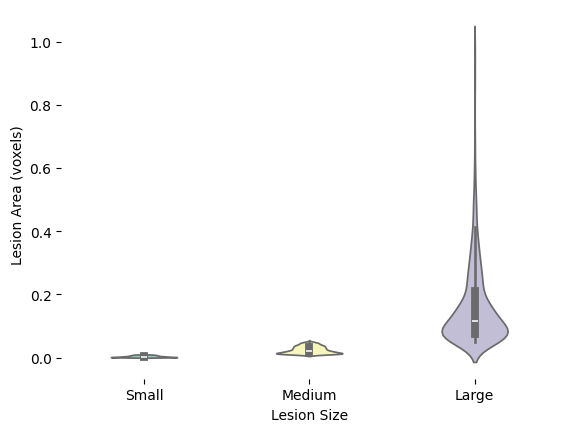

In [26]:
# violin plots to see how is the size distribution inside each lesion size category
records = []
for size in LESION_SIZES[1:]:
    for area in metadata[size]:
        records.append(({"Lesion Size": size, "Lesion Area (voxels)": area}))

df = pd.DataFrame(records, columns=["Lesion Area (voxels)", "Lesion Size"])


sns.violinplot(data=df, x="Lesion Size", y="Lesion Area (voxels)", hue="Lesion Size", palette="Set3", gap=0.5)
sns.despine(left=True, bottom=True)

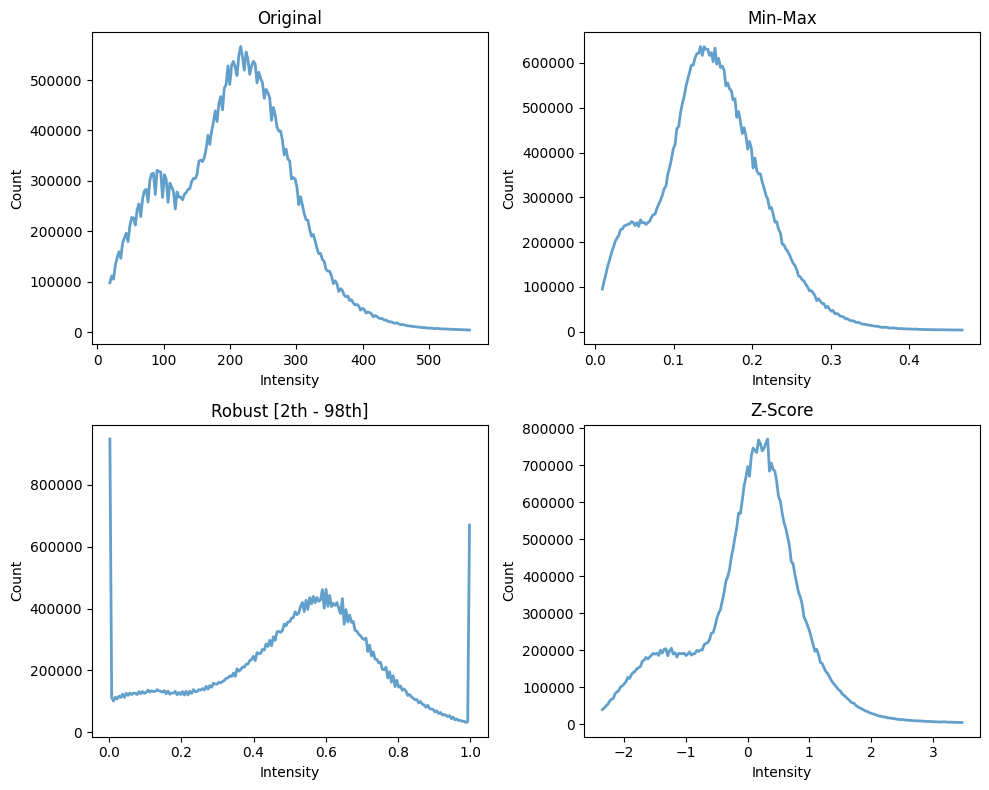

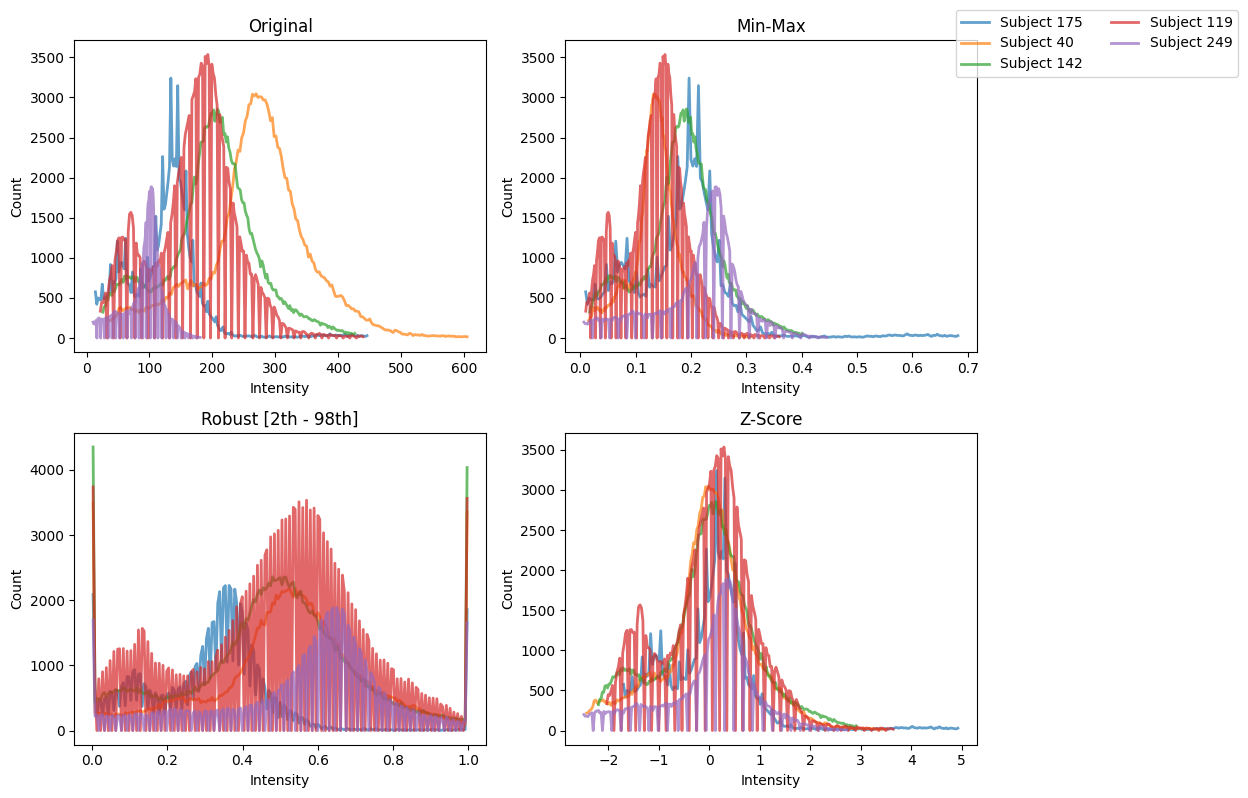

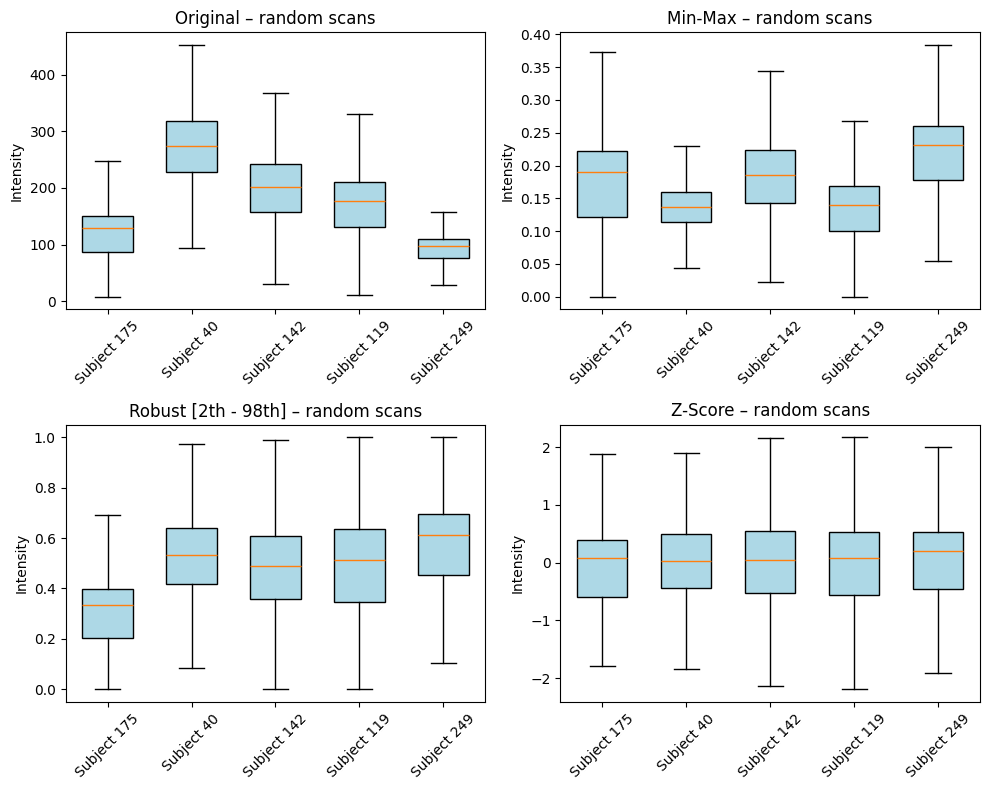

In [23]:
# collect global intensities
raw_intensities = []
robust_intensities = []
minmax_intensities = []
zscore_intensities = []

# we load scan one by one and then discard them to save memory
for scan_fp in tqdm(scans_fps, total=len(scans_fps), desc="Collecting global intensities"):
    scan = load_volume(scan_fp)
    brain_mask = compute_head_mask(scan)

    robust_volume = robust_normalize_volume(scan, brain_mask)
    zscore_volume = z_score_standardization(scan, brain_mask)
    minmax_volume = minmax_normalization(scan, brain_mask)

    raw_intensities.append(scan[brain_mask].ravel())
    robust_intensities.append(robust_volume[brain_mask].ravel())
    zscore_intensities.append(zscore_volume[brain_mask].ravel())
    minmax_intensities.append(minmax_volume[brain_mask].ravel())

    del scan, brain_mask

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

all_intensities = [raw_intensities, minmax_intensities, robust_intensities, zscore_intensities]

titles = ["Original", "Min-Max", "Robust [2th - 98th]", "Z-Score"]

for ax, title, intensities in zip(axes, titles, all_intensities):
    intensities = np.concatenate(intensities)
    centers, counts, _ = make_hist(intensities)
    plot_intensity_distr(centers, ax, title, counts)

# plot random individual intensity distributions
fig.tight_layout()
plt.show()

n_random = 5
n_scans = len(all_intensities[0])
rand_ids = random.sample(range(n_scans), k=n_random)

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, title, intensities in zip(axes, titles, all_intensities):
    random_intensities = [intensities[i] for i in rand_ids]
    # overlay a subset of scans
    for _i, intens in enumerate(random_intensities):
        centers, counts, _ = make_hist(intens)
        plot_intensity_distr(centers, ax, title, counts, label=f"Subject {rand_ids[_i]}" if ax is axes[0] else None)

# global legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc="upper right", bbox_to_anchor=(1.25, 1), ncol=2)
fig.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 2, figsize=(10, 8))
axes = axes.ravel()

for ax, title, intensities in zip(axes, titles, all_intensities):
    # collect 1D arrays for the chosen scans
    data = [intensities[i] for i in rand_ids]

    # positions for grouped boxplots (one group per scan id)
    # here: normalization fixed, scans vary along x
    positions = np.arange(n_random)

    bp = ax.boxplot(
        data,
        positions=positions,
        widths=0.6,
        patch_artist=True,
        showfliers=False,
    )

    # simple coloring
    for box in bp["boxes"]:
        box.set(facecolor="lightblue")

    ax.set_xticks(positions)
    ax.set_xticklabels([f"Subject {i}" for i in rand_ids], rotation=45)
    ax.set_ylabel("Intensity")
    ax.set_title(f"{title} – random scans")

fig.tight_layout()
plt.show()